# Cuadrados mínimos no-lineal paso a paso

Calibración del detector de superficie del Observatorio Pierre Auger

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import minimize

## Datos

Esta demo usa datos abiertos disponibles en https://doi.org/10.5281/zenodo.4487612.

In [2]:
data = pd.read_csv("cuadrados_minimos_nolineal.csv")
xdata = data["energy"]
ydata = data["shower_size"]
yerror = data["shower_size_error"]
print(data)

               id  energy  shower_size  shower_size_error
0     51556398500    4.40        23.17               3.25
1     52816064300    3.84        18.92               3.30
2     53076621500   14.41        61.00               6.29
3     53275880800    5.10        27.04               3.78
4     60256582700    5.43        28.49               3.76
..            ...     ...          ...                ...
306  172996559000    3.09        13.78               2.41
307  173156026200    4.24        21.79               3.00
308  173245270900    5.67        28.32               3.57
309  173275788100   10.18        49.41               5.16
310  173496697500   12.27        61.46               6.00

[311 rows x 4 columns]


## Modelo

In [3]:
def fit_model(energy, par):
    size_0 = 30          # Reference shower size
    energy_0 = par[0]
    power_law_index = par[1]
    return size_0 * np.power(energy / energy_0, 1 / power_law_index)

## Función de costo de un dato

In [4]:
def normal_cost(mu, y, sigma):
    residual = (y - mu) / sigma    
    cost = residual**2
    return cost

## Función de costo

In [5]:
def fit_cost(x, y, ysigma, par):
        mu = fit_model(x, par)
        cost = 0
        for mu1, y1, ysigma1 in zip(mu, y, ysigma):
            cost += normal_cost(mu1, y1, ysigma1)
        return cost

In [6]:
J = lambda par: fit_cost(xdata, ydata, yerror, par)

## Minimización

In [7]:
res = minimize(J, x0=(7, 1))
res

      fun: 389.0265388718711
 hess_inv: array([[2.34670559e-04, 1.85466780e-05],
       [1.85466780e-05, 1.28283893e-04]])
      jac: array([3.81469727e-06, 1.14440918e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 140
      nit: 11
     njev: 43
   status: 2
  success: False
        x: array([6.42829421, 1.03150428])

## Estimadores

In [8]:
par_est = res.x

## Errores

In [9]:
cova = 2*res.hess_inv
error = np.sqrt( np.diagonal(cova) )
rho = cova[0][1]/(error[0]*error[1])
print(f"a = {par_est[0]:.3f} ± {error[0]:.3f}")
print(f"b = {par_est[1]:.3f} ± {error[1]:.3f}")
print(f"ρ = {rho:.2f}")

a = 6.428 ± 0.022
b = 1.032 ± 0.016
ρ = 0.11


## Bondad del ajuste

In [10]:
cost_min = res.fun
ndof = len(xdata) - len(par_est)
pvalor = chi2.sf(cost_min, ndof)
print(f"χ²min = {cost_min:.2f}")
print(f"ndof = {ndof}")
print(f"pvalor = {pvalor*100:.2}%")

χ²min = 389.03
ndof = 309
pvalor = 0.13%


## Plot del ajuste

In [11]:
xfit = np.linspace( xdata.min(), xdata.max(), 256)
mu_est = fit_model(xfit, par_est)

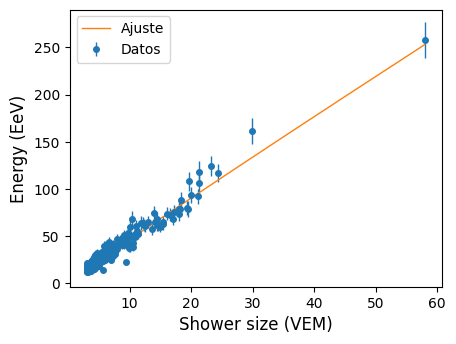

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel("Shower size (VEM)")
ax.set_ylabel("Energy (EeV)")
ax.errorbar(xdata, ydata, yerror,ls='none', marker='o', ms=4, label="Datos")
ax.plot(xfit, mu_est, label="Ajuste")
plt.legend()
plt.show()